In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import sys
dir_path='../control_transition'
sys.path.append(dir_path)

In [4]:
from plot_utils import generate_params, load_zip_json, convert_pd

In [ ]:
import matplotlib
matplotlib.rcParams['figure.dpi'] =300

In [5]:
L_list=[10,20,30,40]
# L_list=[30]
params_list=[
({'nu':0,'de':1,},
{
'p_proj':[0,],
'sC':np.arange(0,500),
'sm':[0],
'L':[L],
# 'maxdim':[2048,4096,],
# 'maxdim':[2**13,],
'maxdim':[256,],
'cutoff': [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-15],
# 'p_ctrl':np.linspace(0,1,21),
'p_ctrl':np.linspace(0,.95,20),
}
)
 for L in L_list]

In [12]:
data_MPS_0_T_dict={'fn':set()}
for fixed_params,vary_params in params_list:
    L= vary_params['L'][0]
    data_MPS_0_T_dict=generate_params(
        fixed_params=fixed_params,
        vary_params=vary_params,
        fn_template='MPS_({nu},{de})_L{L}_pctrl{p_ctrl:.3f}_pproj{p_proj:.3f}_sC{sC}_sm{sm}_maxdim{maxdim}_cutoff{cutoff:.1e}.json',
        fn_dir_template='./',
        input_params_template='',
        load_data=load_zip_json,
        filename=None,
        filelist=None,
        load=True,
        data_dict=data_MPS_0_T_dict,
        zip_fn=f'./MPS_0-1_evo_L{L}.zip'
    )
df_MPS_0_T=convert_pd(data_MPS_0_T_dict,names=['Metrics','cutoff','sm','sC','maxdim','p_ctrl','L','p_proj'])

generate_params: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90000/90000 [09:52<00:00, 151.81it/s]


In [165]:
df_MPS_0_T.to_pickle('./MPS_0-1_evo_L.pickle')

# New trial 20250502

In [14]:
params_list[0][1]['cutoff']

[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-08, 1e-10, 1e-15]

In [15]:
params_list[0][1]['p_ctrl']

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [16]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

maxbond_max_mean_dict = {}
maxbond_max_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            # maxbond_max_mean_list=[]
            # maxbond_max_sem_list=[]
            # p_list_=[]
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                maxbond_max_mean = np.stack(dataset)[:,:,-1].max(axis=1).mean(axis=0)
                maxbond_max_sem = np.stack(dataset)[:,:,-1].max(axis=1).std(axis=0)/np.sqrt(len(dataset))
                # p_list_.append(p)
                # maxbond_max_mean_list.append(maxbond_max_mean)
                # maxbond_max_sem_list.append(maxbond_max_sem)

                maxbond_max_mean_dict[(L,cutoff,p)] = maxbond_max_mean
                maxbond_max_sem_dict[(L,cutoff,p)] = maxbond_max_sem

                
            # ax.plot(p_list_,maxbond_max_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

maxbond_max_mean_df=convert_pd(maxbond_max_mean_dict,names=['L','cutoff','p'])
maxbond_max_sem_df=convert_pd(maxbond_max_sem_dict,names=['L','cutoff','p'])

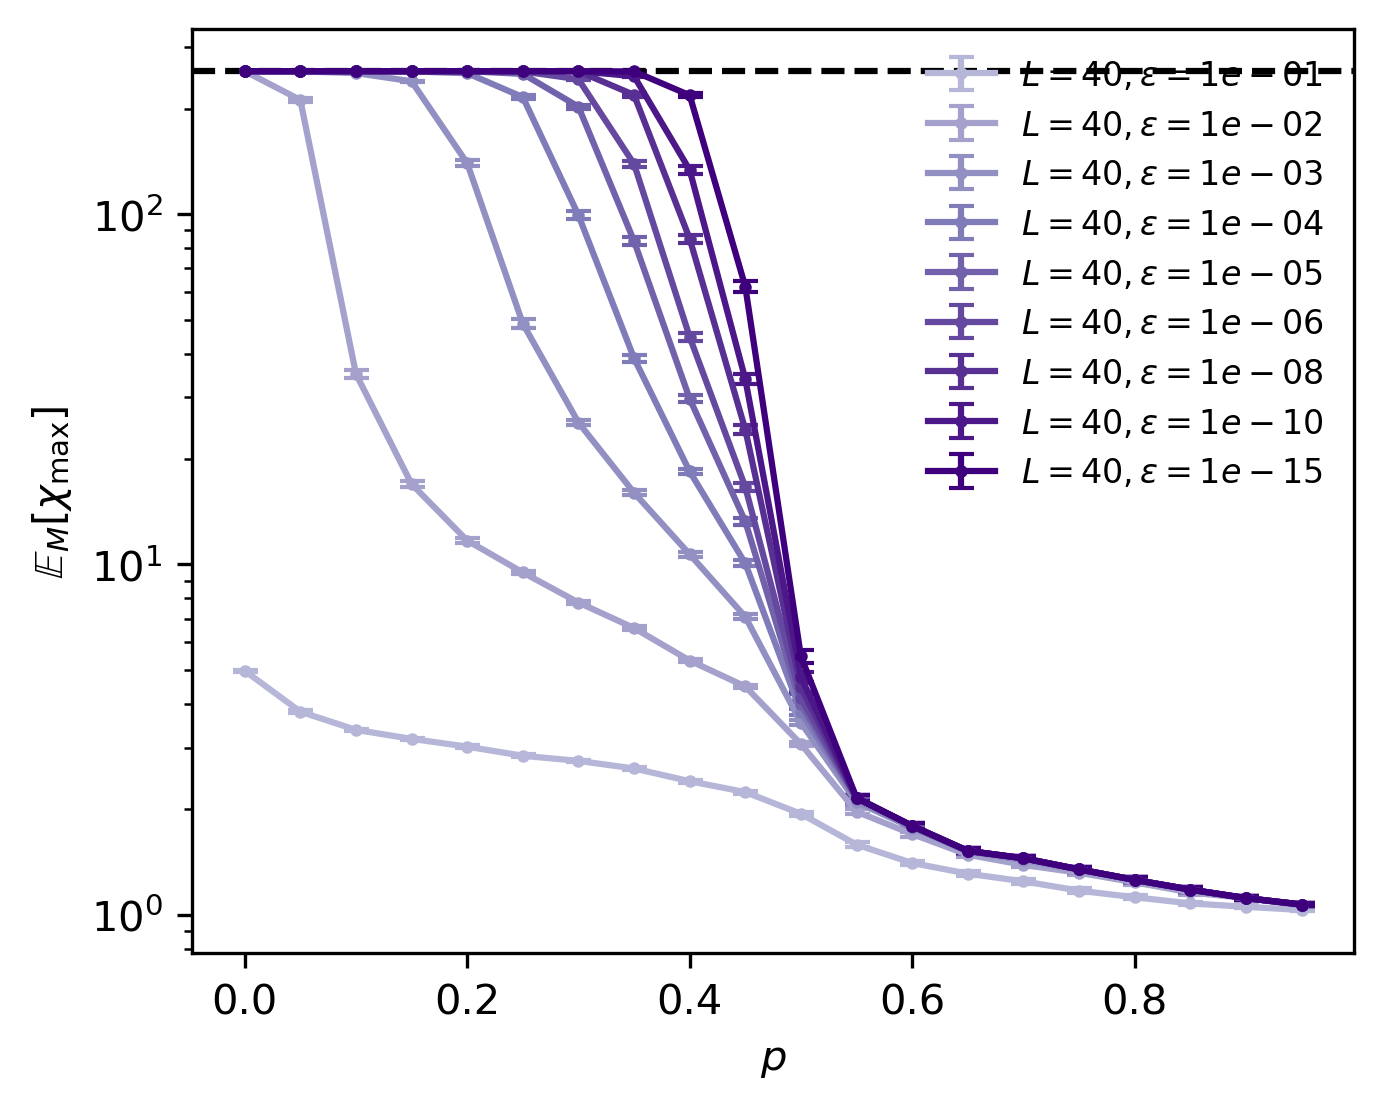

In [24]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([40]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = maxbond_max_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,maxbond_max_mean_df_.values.flatten(),yerr=maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]$')
ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=8,loc='upper right',frameon=False)

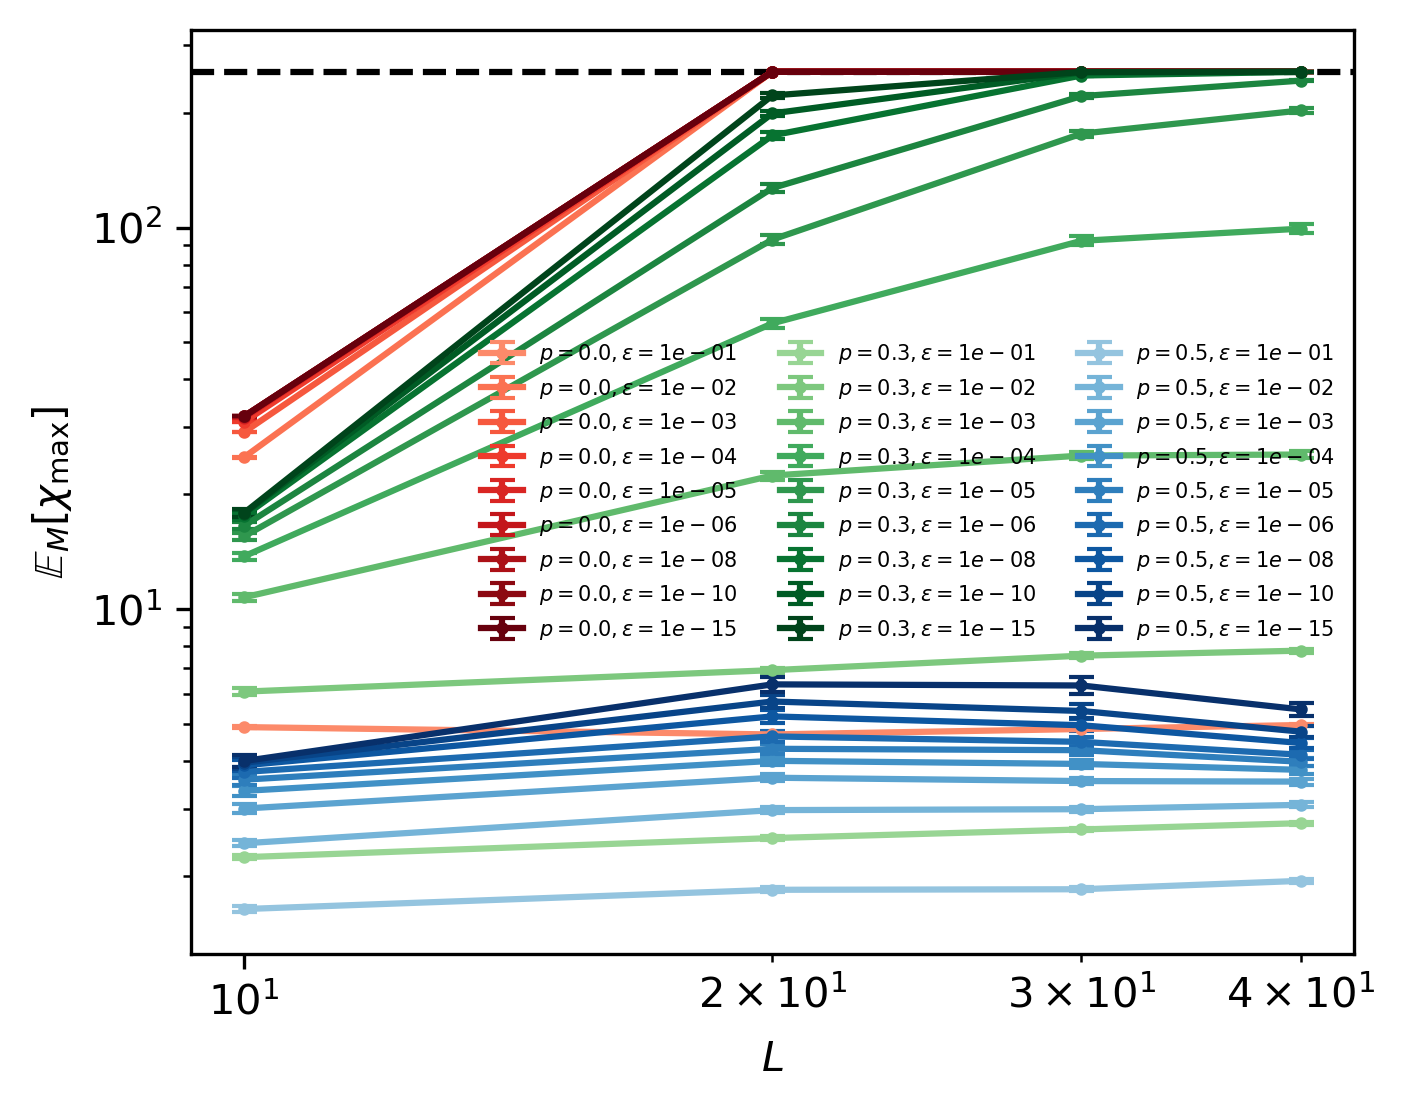

In [29]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.,.3,.5]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(p,level='p').xs(cutoff,level='cutoff')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(p,level='p').xs(cutoff,level='cutoff')
        L_list_ = maxbond_max_mean_df_.index.get_level_values('L')
        ax.errorbar(L_list_,maxbond_max_mean_df_.values.flatten(),yerr=maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]$')
ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=5,frameon=False,ncols=3)

In [170]:
1

1

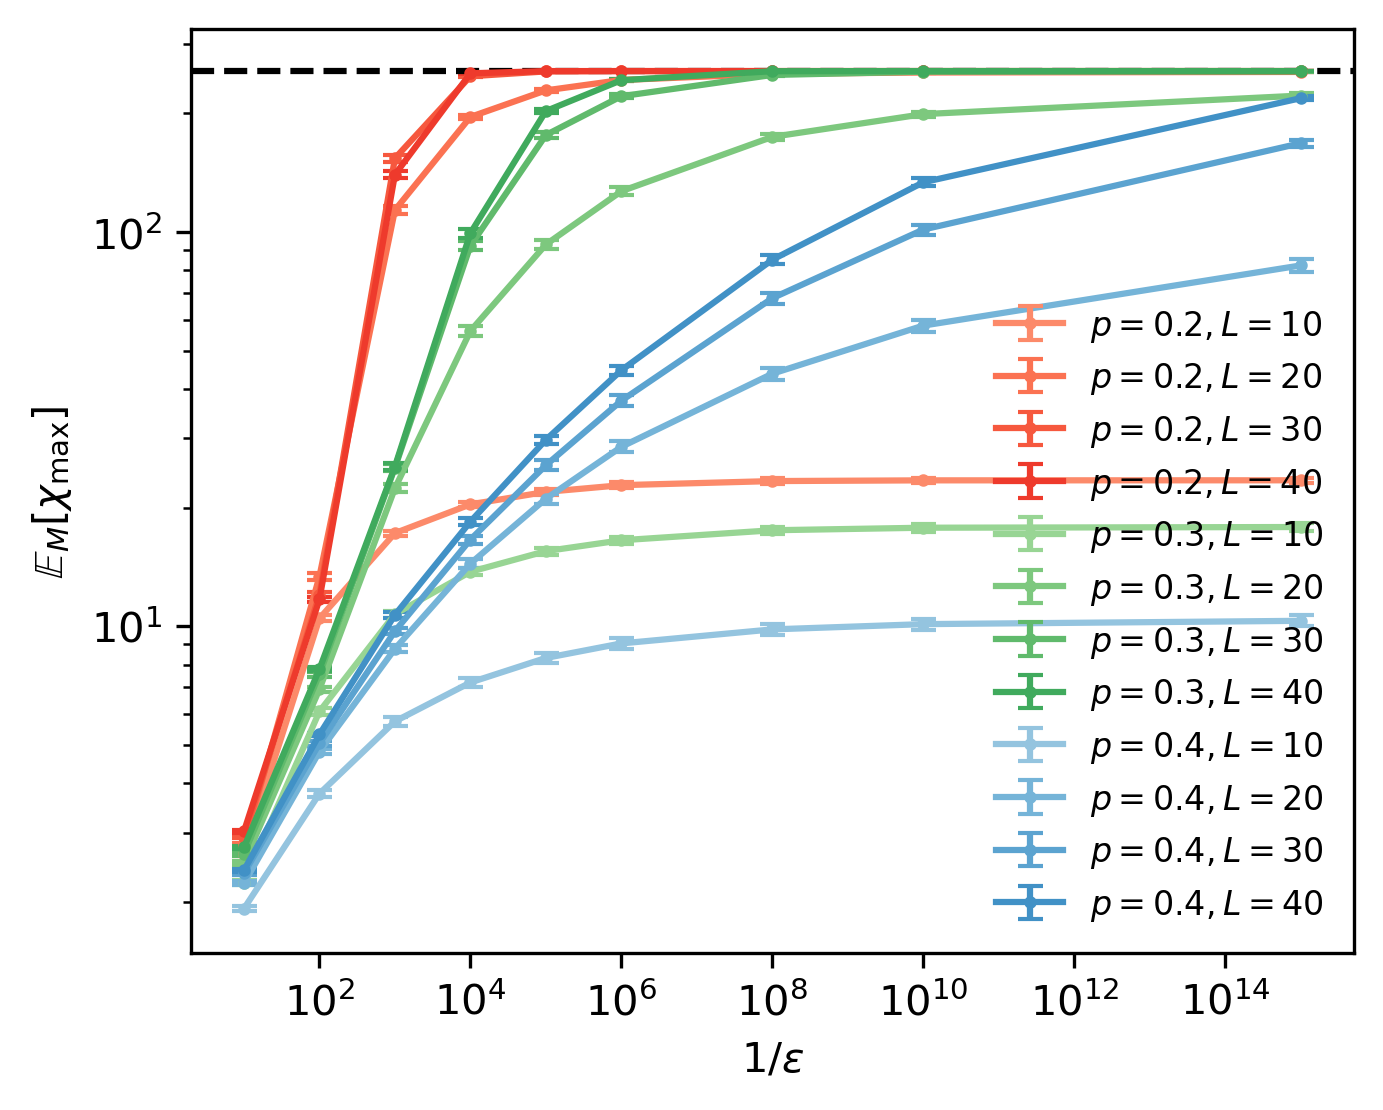

In [46]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.2,.3,.4]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(p,level='p').xs(L,level='L')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(p,level='p').xs(L,level='L')
        cutoff_list = maxbond_max_mean_df_.index.get_level_values('cutoff')
        ax.errorbar(1/cutoff_list,maxbond_max_mean_df_.values.flatten(),yerr=maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]$')
ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=8,frameon=False)

In [61]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

t_mean_dict = {}
t_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('time',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            # t_mean_list=[]
            # t_sem_list=[]
            # p_list_=[]
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                t_mean = np.stack(dataset).mean(axis=0)
                t_sem = np.stack(dataset).std(axis=0)/np.sqrt(len(dataset))
                # p_list_.append(p)
                # t_mean_list.append(t_mean)
                # t_sem_list.append(t_sem)

                t_mean_dict[(L,cutoff,p)] = t_mean
                t_sem_dict[(L,cutoff,p)] = t_sem

                
            # ax.plot(p_list_,t_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

t_mean_df=convert_pd(t_mean_dict,names=['L','cutoff','p'])
t_sem_df=convert_pd(t_sem_dict,names=['L','cutoff','p'])

Text(0, 0.5, '$\\mathbb{E}_M[t]$')

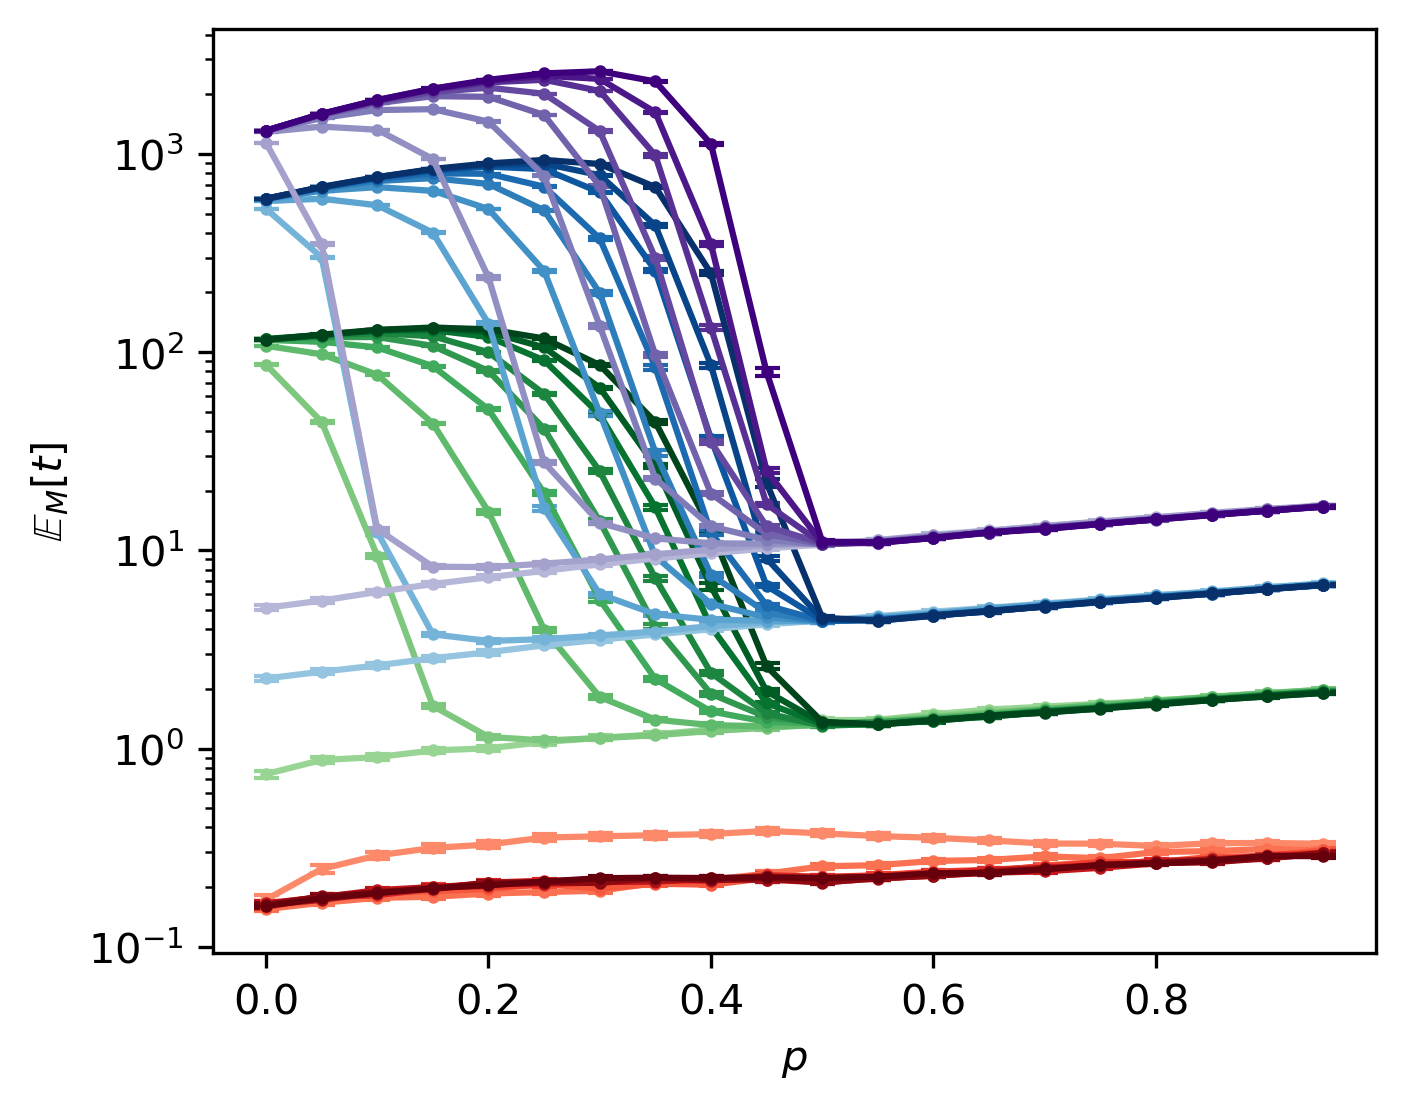

In [62]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([10,20,30,40]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        t_mean_df_ = t_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        t_sem_df_ = t_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = t_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,t_mean_df_.values.flatten(),yerr=t_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[t]$')
# ax.axhline(2<<7,linestyle='--',color='black')
# ax.legend(fontsize=8,loc='upper right',frameon=False)

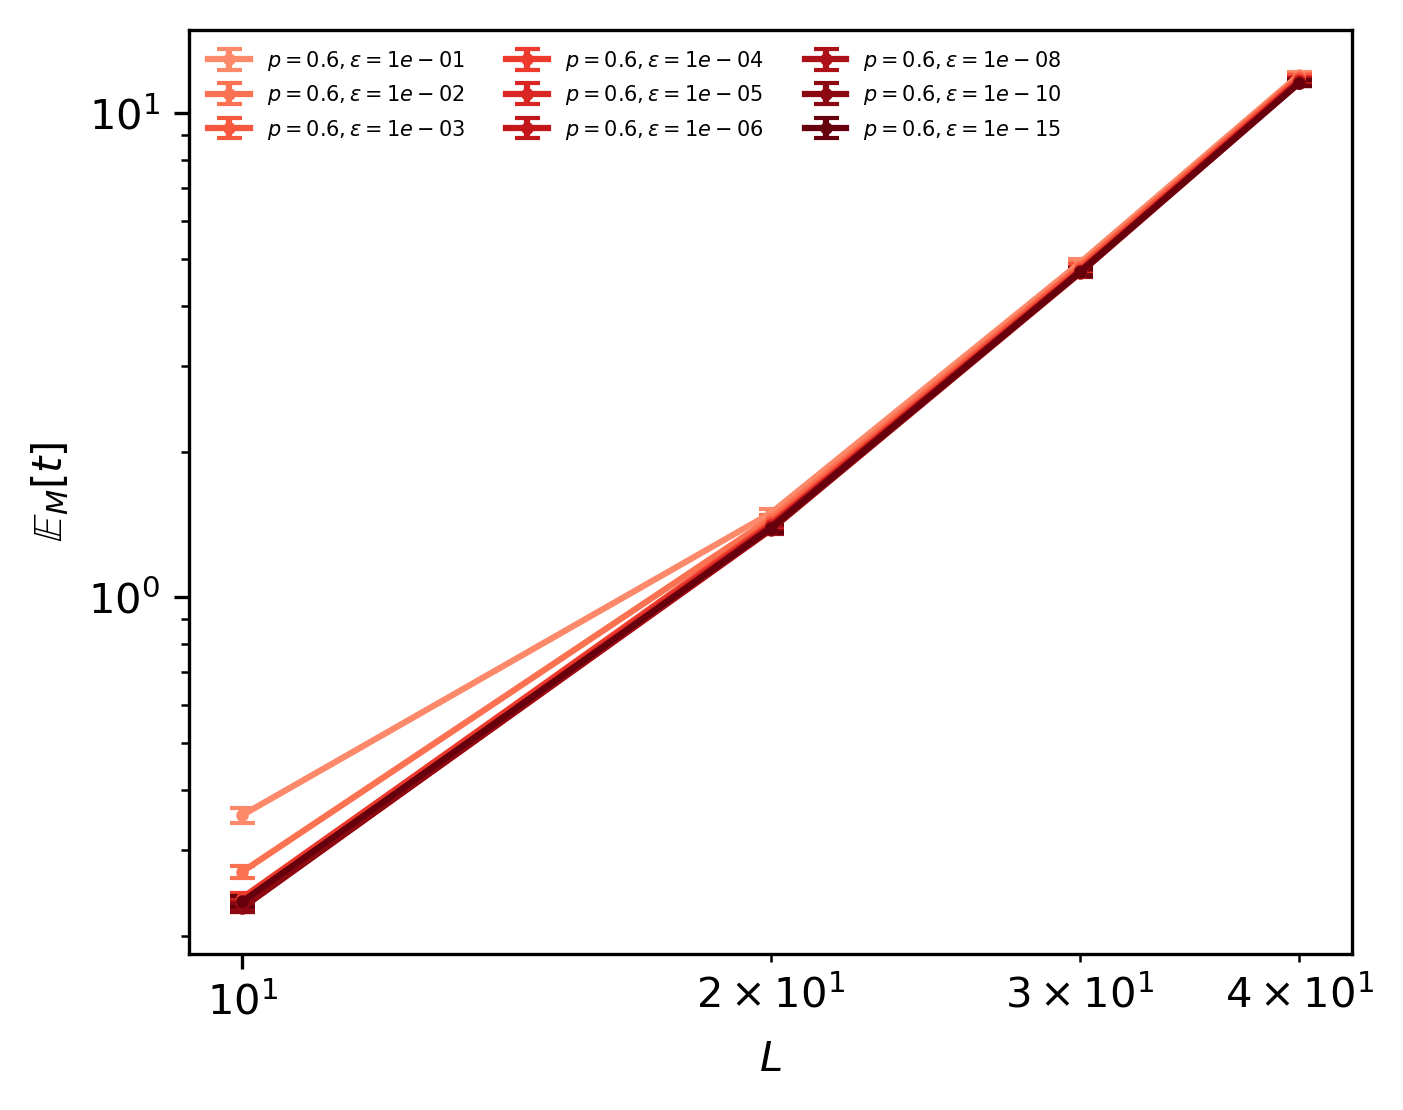

In [95]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.6,]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        t_mean_df_ = t_mean_df.xs(p,level='p').xs(cutoff,level='cutoff')
        t_sem_df_ = t_sem_df.xs(p,level='p').xs(cutoff,level='cutoff')
        L_list_ = t_mean_df_.index.get_level_values('L')
        ax.errorbar(L_list_,t_mean_df_.values.flatten(),yerr=t_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathbb{E}_M[t]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=5,frameon=False,ncols=3)

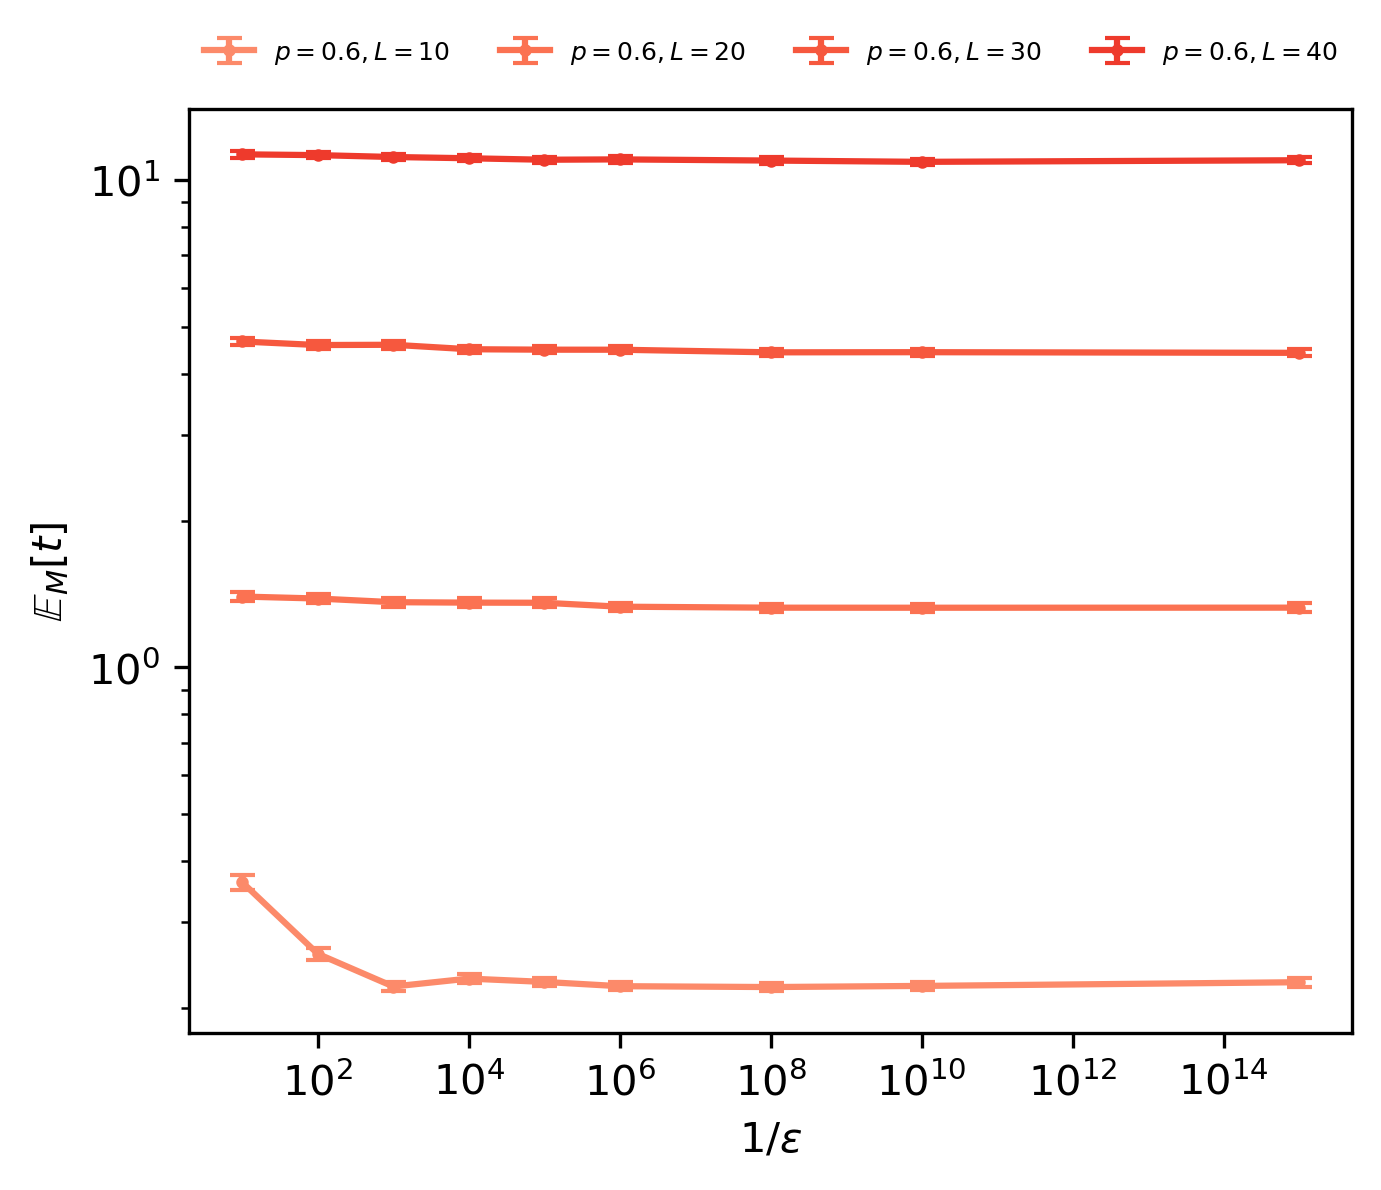

In [88]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.55]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        t_mean_df_ = t_mean_df.xs(p,level='p').xs(L,level='L')
        t_sem_df_ = t_sem_df.xs(p,level='p').xs(L,level='L')
        cutoff_list = t_mean_df_.index.get_level_values('cutoff')
        ax.errorbar(1/cutoff_list,t_mean_df_.values.flatten(),yerr=t_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[t]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,frameon=False,ncols=4,loc='upper center',bbox_to_anchor=(0.5, 1.1))

## Integral_maxbond

In [107]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

integral_maxbond_max_mean_dict = {}
integral_maxbond_max_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                integral_maxbond_max_mean = np.log(np.stack(dataset)).max(axis=1).sum(axis=-1).mean(axis=0)
                integral_maxbond_max_sem = np.log(np.stack(dataset)).max(axis=1).sum(axis=-1).std(axis=0)/np.sqrt(len(dataset))

                integral_maxbond_max_mean_dict[(L,cutoff,p)] = integral_maxbond_max_mean
                integral_maxbond_max_sem_dict[(L,cutoff,p)] = integral_maxbond_max_sem

                
            # ax.plot(p_list_,integral_maxbond_max_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

integral_maxbond_max_mean_df=convert_pd(integral_maxbond_max_mean_dict,names=['L','cutoff','p'])
integral_maxbond_max_sem_df=convert_pd(integral_maxbond_max_sem_dict,names=['L','cutoff','p'])

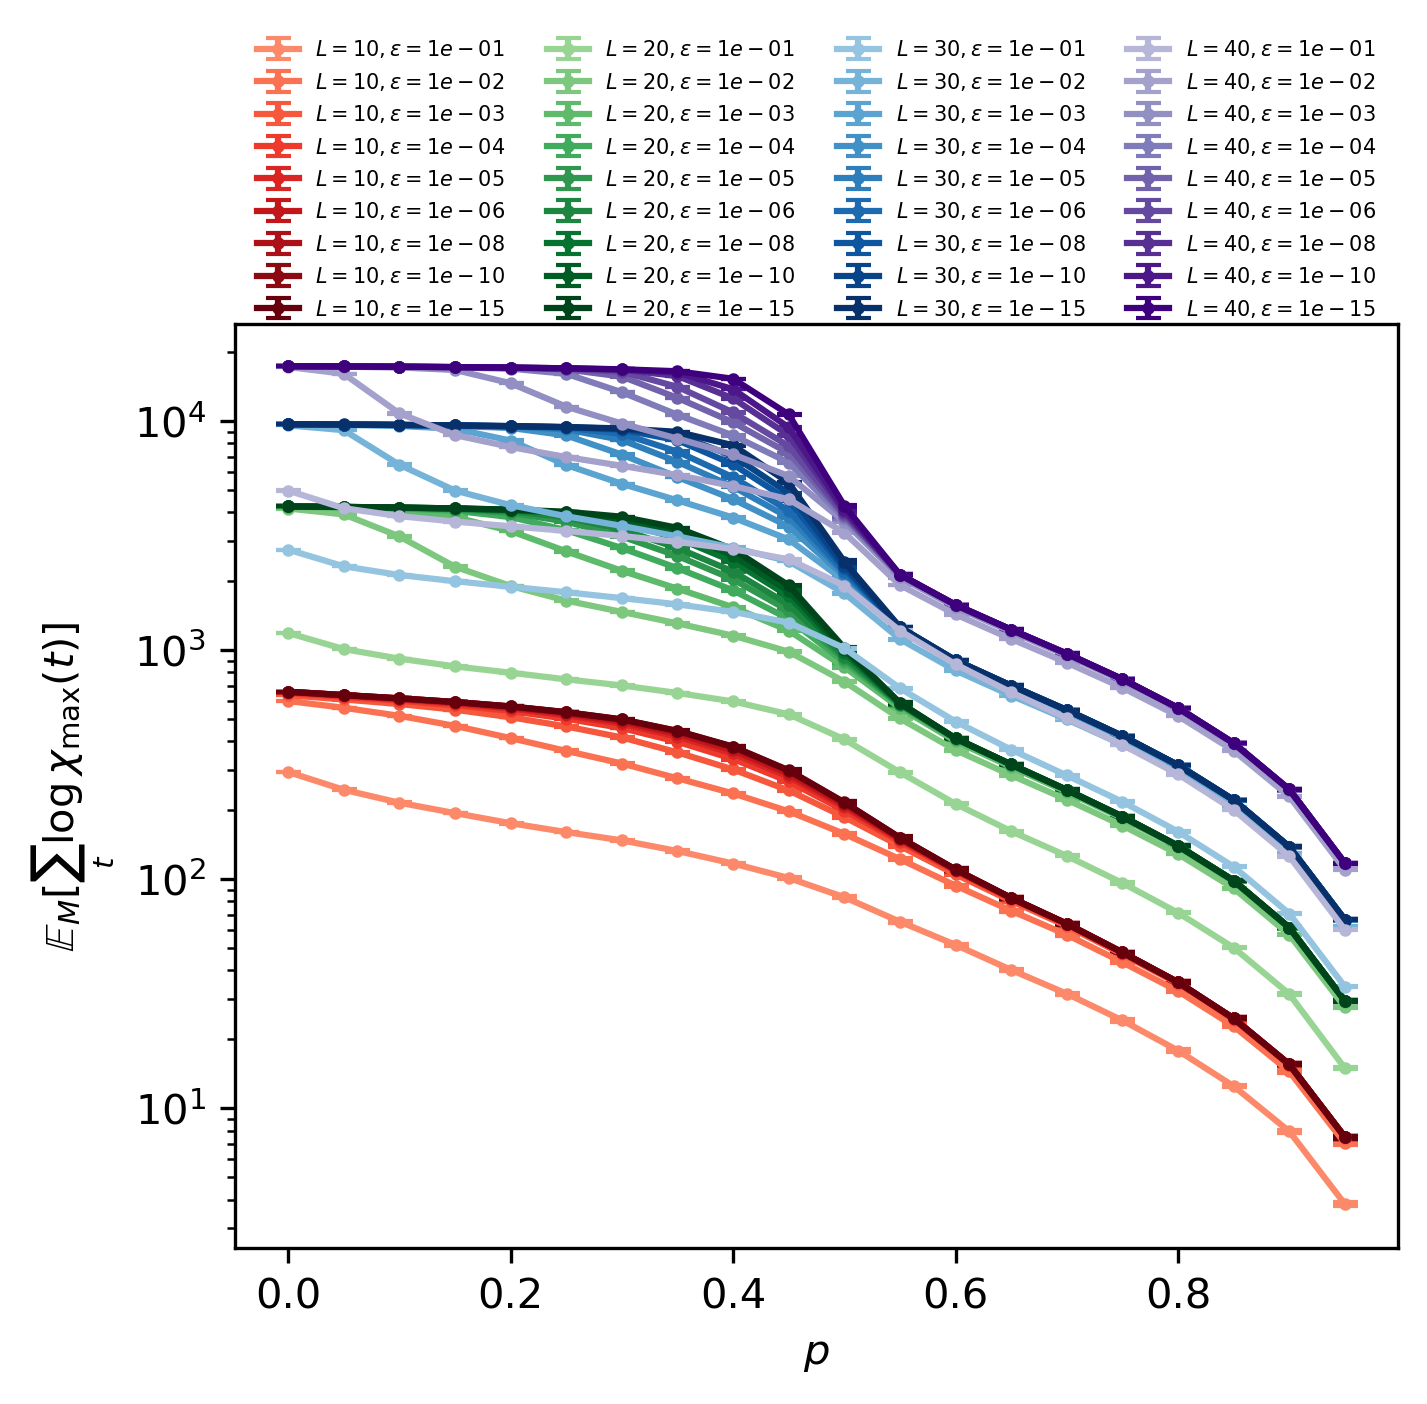

In [134]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([10,20,30,40,]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        color_ = next(cmap)
        integral_maxbond_max_mean_df_ = integral_maxbond_max_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        integral_maxbond_max_sem_df_ = integral_maxbond_max_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = integral_maxbond_max_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,integral_maxbond_max_mean_df_.values.flatten(),yerr=integral_maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = color_,capsize=3,markersize=4)
        # ax.axhline(2**4*L**2,linestyle='--',color=color_)

ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[\sum_t\log\chi_{\max}(t)]$')
ax.legend(fontsize=5,loc='upper center',frameon=False,ncols=4,bbox_to_anchor=(.5, 1.33))

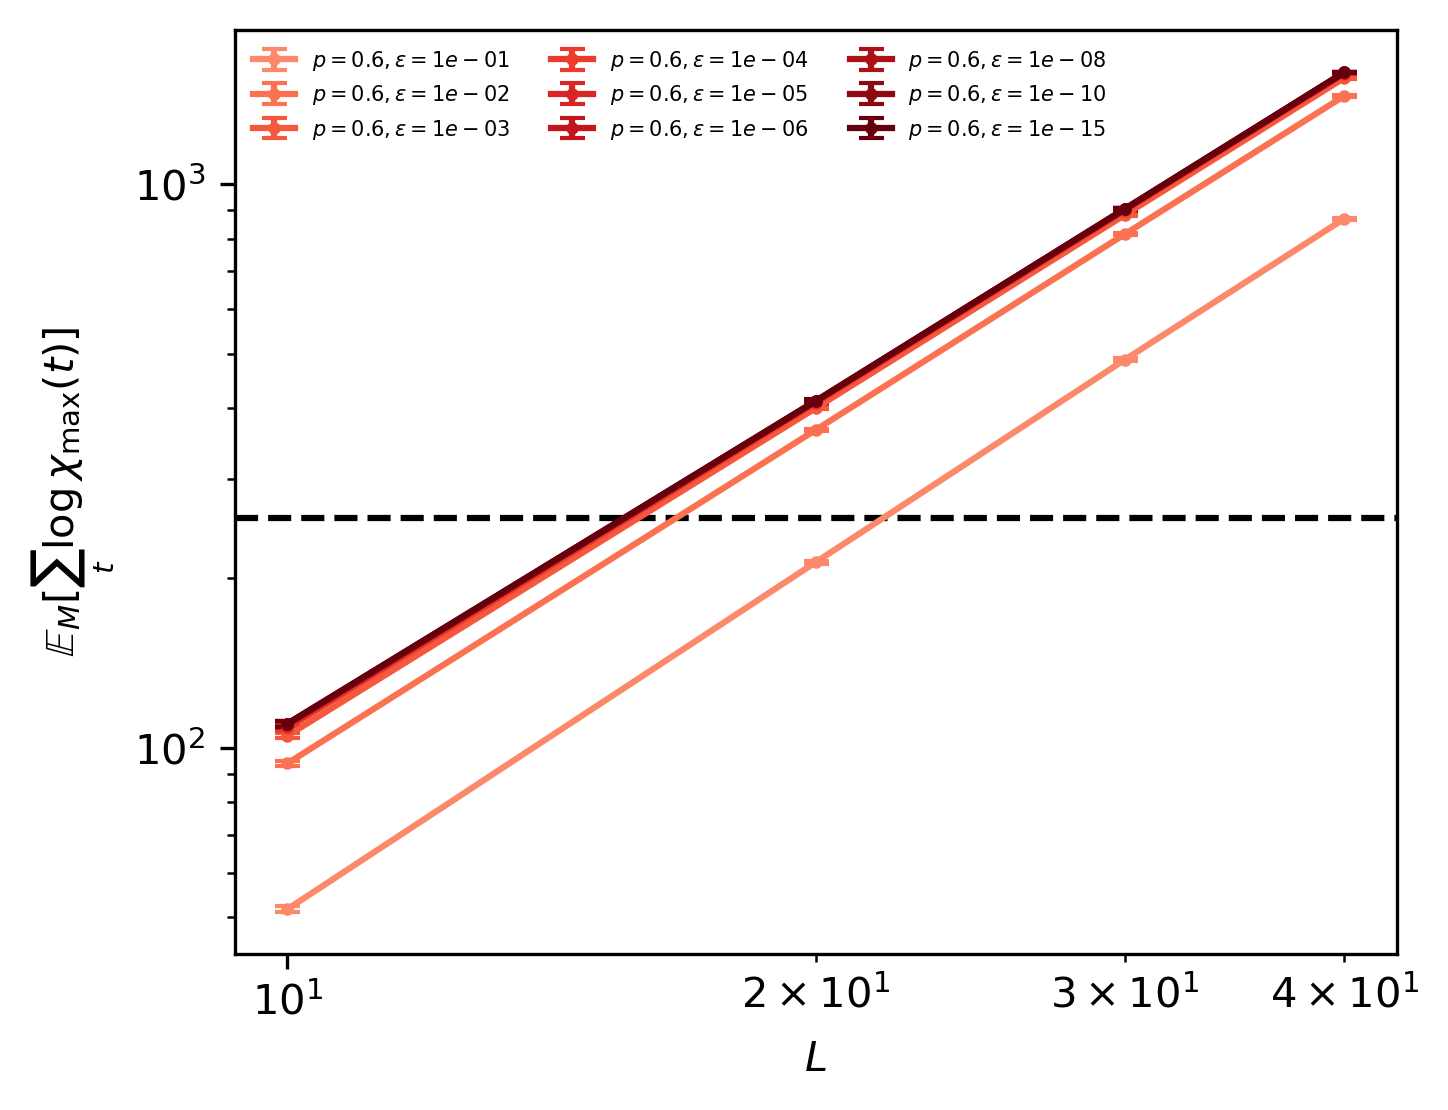

In [145]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.6,]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        integral_maxbond_max_mean_df_ = integral_maxbond_max_mean_df.xs(p,level='p').xs(cutoff,level='cutoff')
        integral_maxbond_max_sem_df_ = integral_maxbond_max_sem_df.xs(p,level='p').xs(cutoff,level='cutoff')
        L_list_ = integral_maxbond_max_mean_df_.index.get_level_values('L')
        ax.errorbar(L_list_,integral_maxbond_max_mean_df_.values.flatten(),yerr=integral_maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathbb{E}_M[\sum_t\log\chi_{\max}(t)]$')

ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=5,frameon=False,ncols=3)

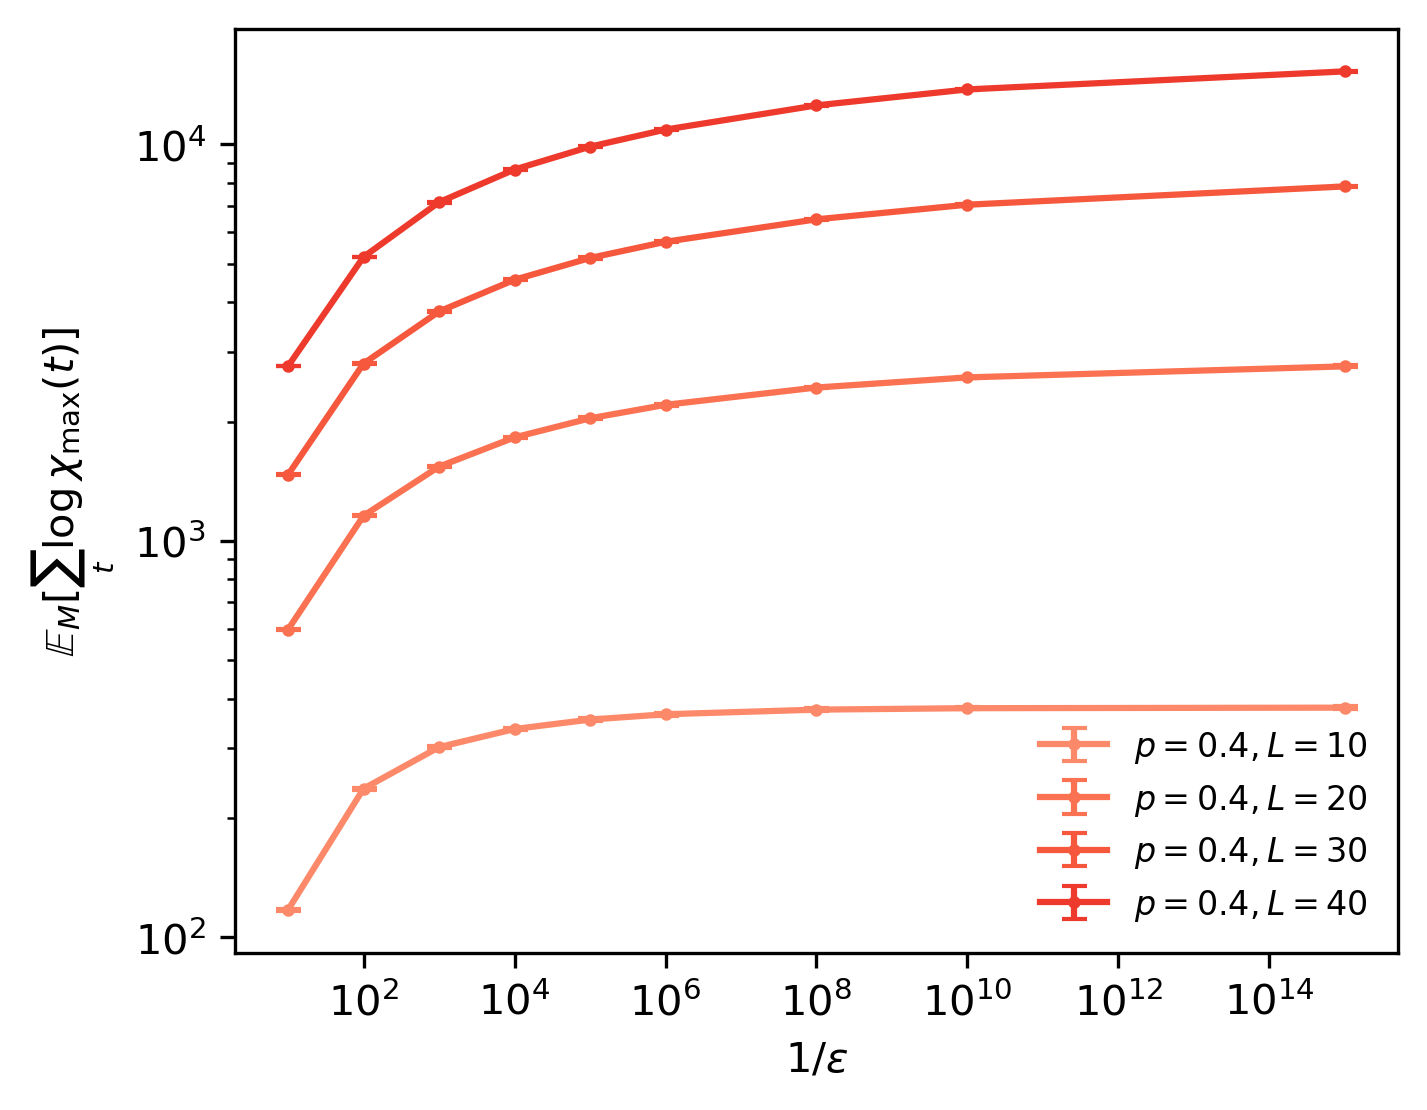

In [153]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.4]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        integral_maxbond_max_mean_df_ = integral_maxbond_max_mean_df.xs(p,level='p').xs(L,level='L')
        integral_maxbond_max_sem_df_ = integral_maxbond_max_sem_df.xs(p,level='p').xs(L,level='L')
        cutoff_list = integral_maxbond_max_mean_df_.index.get_level_values('cutoff')
        ax.errorbar(1/cutoff_list,integral_maxbond_max_mean_df_.values.flatten(),yerr=integral_maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[\sum_t\log\chi_{\max}(t)]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=8,frameon=False)

In [159]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

success_mean_dict = {}
success_sem_dict = {}
for idx,L in enumerate([10,]):
    
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            # t_mean_list=[]
            # t_sem_list=[]
            # p_list_=[]
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                t_mean = np.stack(dataset).mean(axis=0)
                t_sem = np.stack(dataset).std(axis=0)/np.sqrt(len(dataset))
                # p_list_.append(p)
                # t_mean_list.append(t_mean)
                # t_sem_list.append(t_sem)

                success_mean_dict[(L,cutoff,p)] = t_mean
                success_sem_dict[(L,cutoff,p)] = t_sem

                
            # ax.plot(p_list_,t_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

success_mean_df=convert_pd(success_mean_dict,names=['L','cutoff','p'])
success_sem_df=convert_pd(success_sem_dict,names=['L','cutoff','p'])

In [ ]:
(~(dataset.iloc[0]<(2<<7)))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Text(0, 0.5, '$\\mathbb{E}_M[t]$')

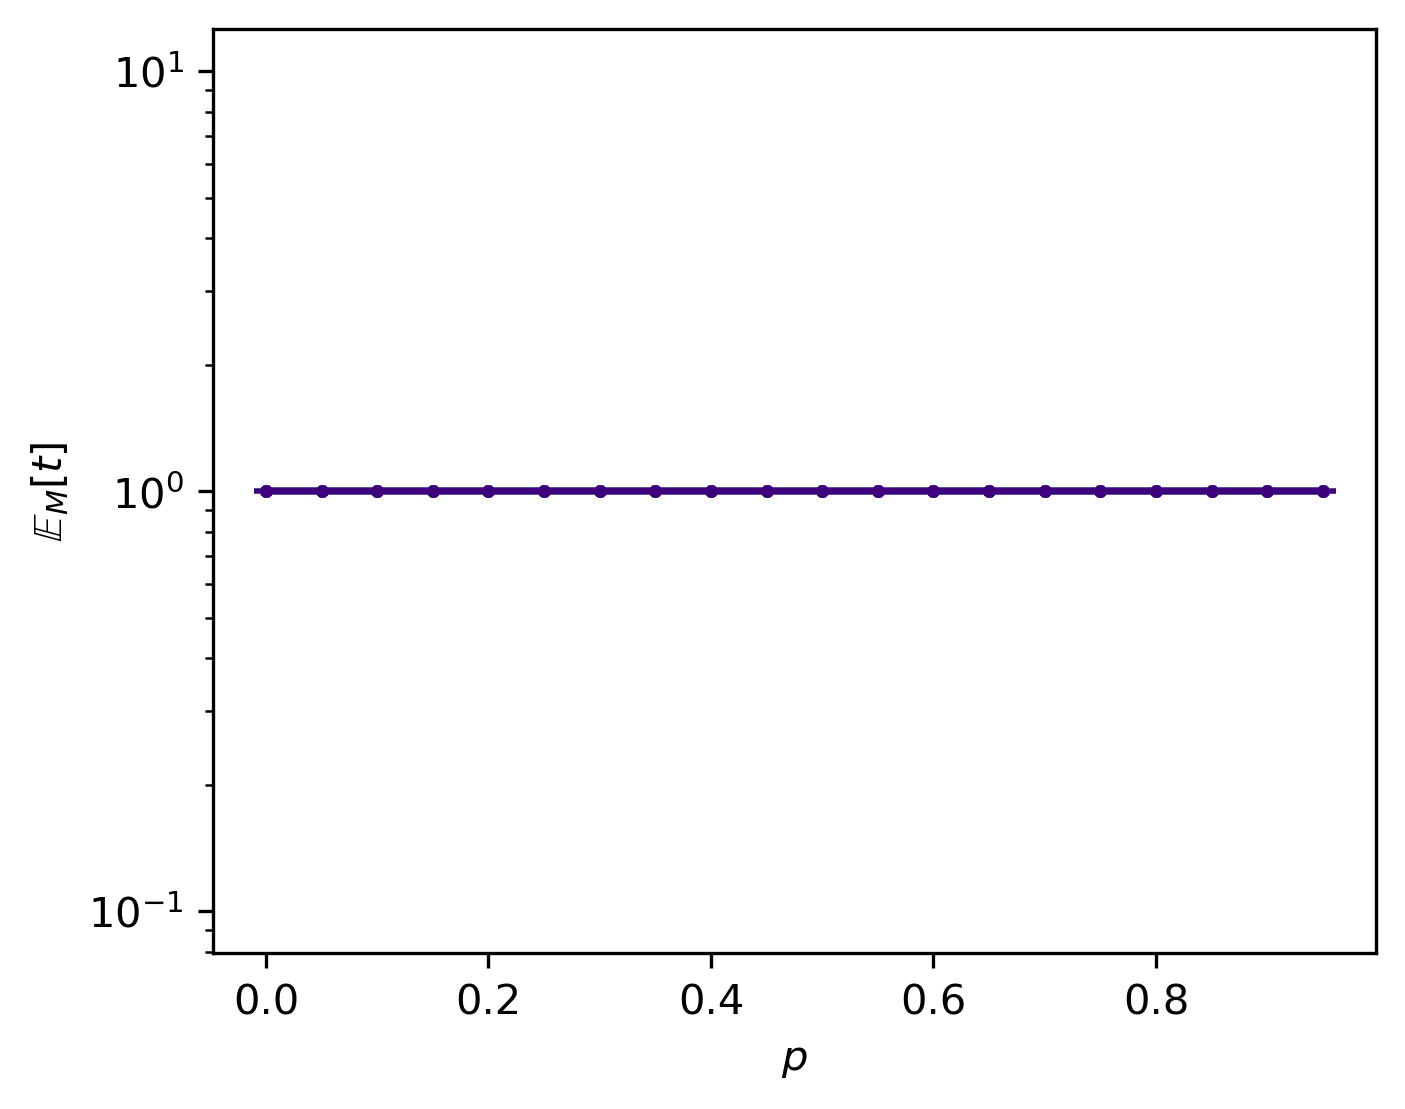

In [156]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([10,20,30,40]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        success_mean_df_ = t_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        success_sem_df_ = t_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = success_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,success_mean_df_.values.flatten(),yerr=success_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[t]$')
# ax.axhline(2<<7,linestyle='--',color='black')
# ax.legend(fontsize=8,loc='upper right',frameon=False)

# Legacy

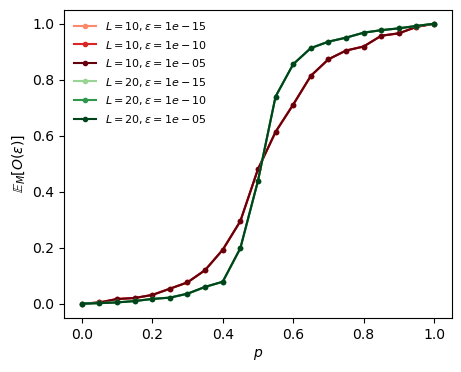

In [9]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2**13
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-15,1e-10,1e-5]
for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        O_list=[]
        p_list_=[]
        for p in p_list:
            # try:
            O=np.stack(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
            p_list_.append(p)
            O_list.append(O)
            # except:
            #     pass
        ax.plot(p_list_,O_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
# ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M [O(\epsilon)]$')

# ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

In [126]:
p=0.1
L=10
cutoff = 1e-5
(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).sort_index(level='sC')

sm  sC   p_proj
0   0    0.0       -0.004558274595816303
    1    0.0        -0.03729218460092394
    2    0.0          0.1260042657463911
    3    0.0       -0.040253425091019764
    4    0.0       -0.010537753896863289
                           ...          
    495  0.0        0.020050608910366502
    496  0.0        0.011938877348414912
    497  0.0        -0.05279317843283828
    498  0.0         0.05727500334097861
    499  0.0        -0.03041658906607565
Name: observations, Length: 500, dtype: object

In [10]:
p=0.1
L=10
cutoff=1e-15
(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).sort_index(level='sC')

sm  sC   p_proj
0   0    0.0       -0.0041198070862553645
    1    0.0         -0.03741550917520097
    2    0.0           0.1261808824893993
    3    0.0         -0.04063009354343034
    4    0.0        -0.010798933949134424
                            ...          
    495  0.0         0.019985760314326344
    496  0.0         0.011740046699106974
    497  0.0         -0.05305816808317391
    498  0.0         0.057240960878366165
    499  0.0        -0.030329875507481126
Name: observations, Length: 500, dtype: object

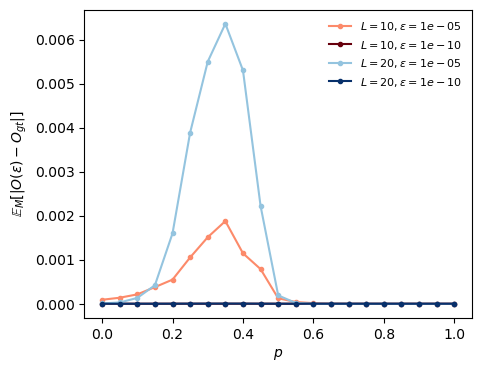

In [11]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2**13
cmap_list = [plt.cm.Reds,plt.cm.Blues,plt.cm.Blues]
cutoff_list = [1e-5,1e-10,]
cutoff_min=1e-15
for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        delta_O_list=[]
        p_list_=[]
        for p in p_list:
            # try:
            O=(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations'])
            O_gt = (df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff_min,level='cutoff').xs(maxdim,level='maxdim')['observations'])
            p_list_.append(p)
            delta_O_list.append((np.abs(O-O_gt)).mean())
            # except:
            #     pass
        ax.plot(p_list_,delta_O_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
# ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M [|O(\epsilon)-O_{gt}|]$')
# ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

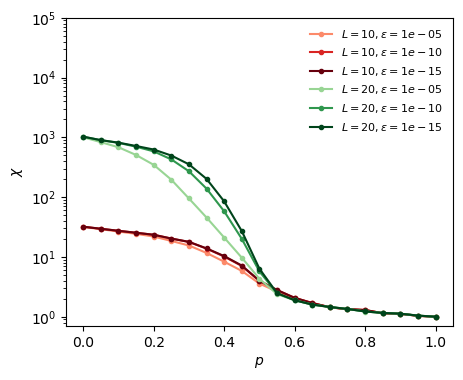

In [12]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2**13
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-5,1e-10,1e-15]

for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_list=[]
        p_list_=[]
        for p in p_list:
            # try:
            maxbond=np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
            p_list_.append(p)
            maxbond_list.append(maxbond)
            # except:
            #     pass
        ax.plot(p_list_,maxbond_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

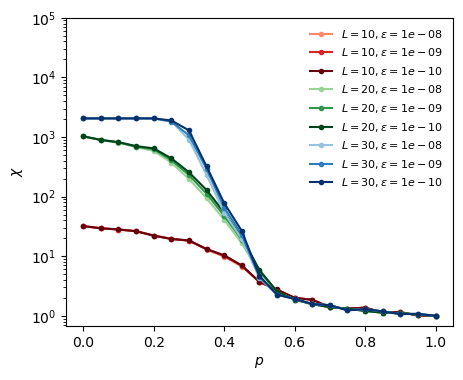

In [ ]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2048
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-8,1e-9,1e-10]
for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_list=[]
        p_list_=[]
        for p in p_list:
            try:
                maxbond=np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
                p_list_.append(p)
                maxbond_list.append(maxbond)
            except:
                pass
        ax.plot(p_list_,maxbond_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

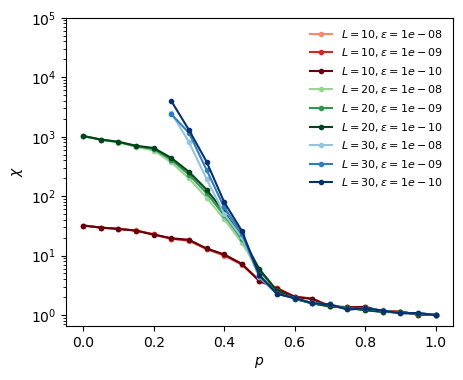

In [33]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=4096
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-8,1e-9,1e-10]
for idx,L in enumerate([10,20,30]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_list=[]
        p_list_=[]
        for p in p_list:
            try:
                maxbond=np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
                p_list_.append(p)
                maxbond_list.append(maxbond)
            except:
                pass
        ax.plot(p_list_,maxbond_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

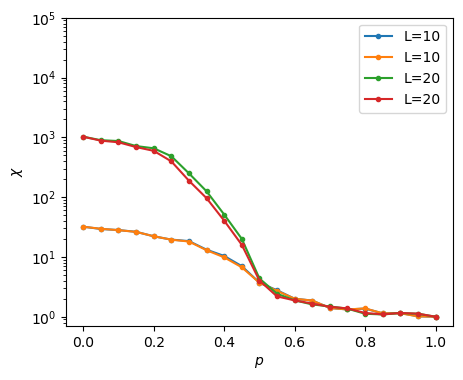

In [29]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
for L in [10,20]:
    maxbond_list=[np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(1e-10,level='cutoff').xs(2048,level='maxdim')['observations']).mean() for p in p_list]
    ax.plot(p_list,maxbond_list,'.-',label=f'L={L}')

    maxbond_list=[np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(1e-8,level='cutoff').xs(2048,level='maxdim')['observations']).mean() for p in p_list]
    ax.plot(p_list,maxbond_list,'.-',label=f'L={L}')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend()

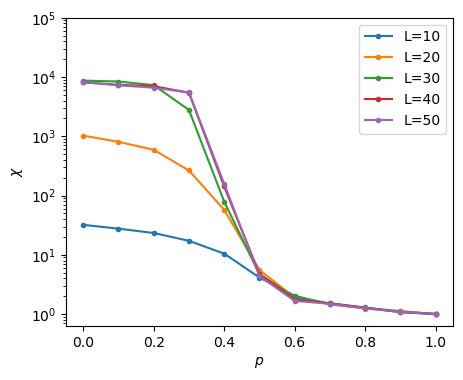

In [17]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
for L in [10,20,30,40,50]:
    maxbond_list=[np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L')['observations']).mean() for p in p_list]
    ax.plot(p_list,maxbond_list,'.-',label=f'L={L}')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend()

In [18]:
print(f"np.complex64: {np.dtype(np.complex64).itemsize} bytes")
print(f"np.complex128 (default np.complex): {np.dtype(np.complex128).itemsize} bytes")
if hasattr(np, 'complex256'):
    print(f"np.complex256: {np.dtype(np.complex256).itemsize} bytes")
else:
    print("np.complex256 not available on this platform")

np.complex64: 8 bytes
np.complex128 (default np.complex): 16 bytes
np.complex256: 32 bytes


In [21]:
np.hstack(df_MPS_0_T.xs('success',level='Metrics')['observations']).sum()

11000

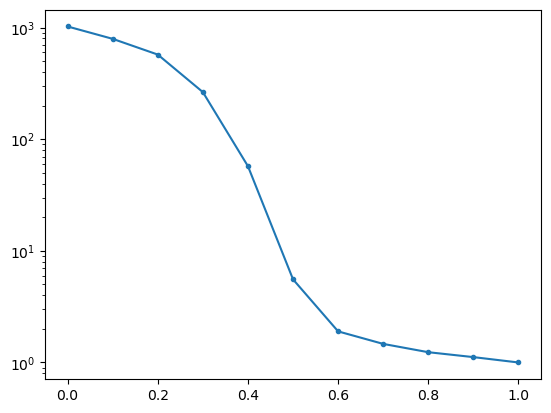

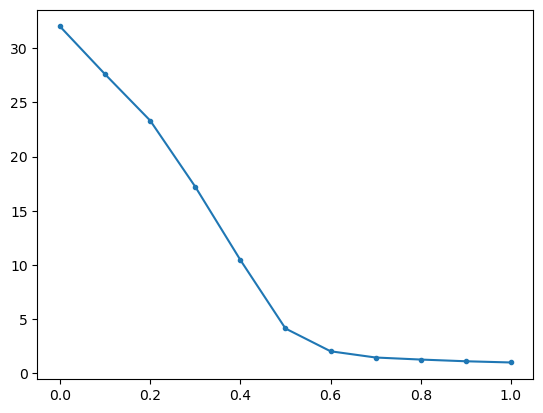

In [ ]:
plt.plot(p_list,maxbond_list,'.-')

In [25]:
p_list

Index([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], dtype='float64', name='p_ctrl')